# 1D harmonic oscillator PINN for COVID


## 1D oscillator equations

1D damped harmonic oscillator ODE (compare https://beltoforion.de/en/harmonic_oscillator/):
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + k(x-b) = 0~,
$$
Here, b is the x-value around which the trajectory oscillates. For the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
we can find the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t)) + b~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

We are using PINN to enforce the ODE while training a neural network to predict COVID case numbers. At the same time we are learning the model parameters $k, \mu, b$. We are assuming the mass $m=1$.

In [1]:
# import necessary python packages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

### 1. Load COVID data
 

In [2]:
# world-wide COVID cases, daily, since start of pandemic
covid_world = np.loadtxt('covid_world.dat')

# make time array
days = np.arange(0,covid_world.shape[0])
years = days/365

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# smooth data to take out weekly fulctuations due to reporting
covid_world_smooth = movingaverage(covid_world[:,1],7)


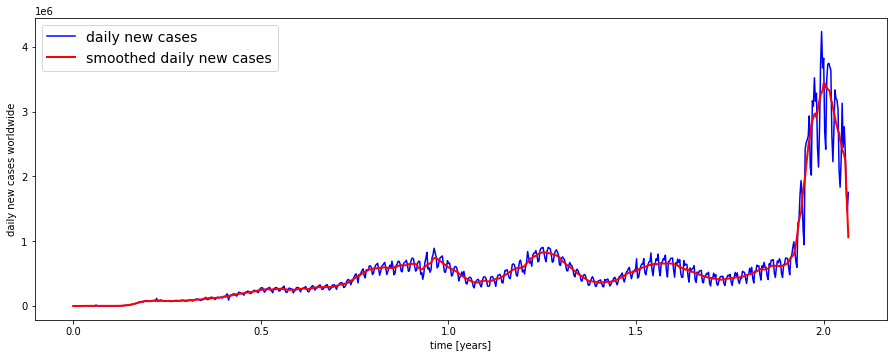

In [3]:
# plot data
plt.figure(figsize=(1100/72,400/72))
plt.plot(years,covid_world[:,1],color='blue',label='daily new cases')
plt.plot(years,covid_world_smooth,linewidth=2.0,color='red', label='smoothed daily new cases')
plt.xlabel('time [years]')
plt.ylabel('daily new cases worldwide')
plt.legend(loc='upper left',fontsize=14)

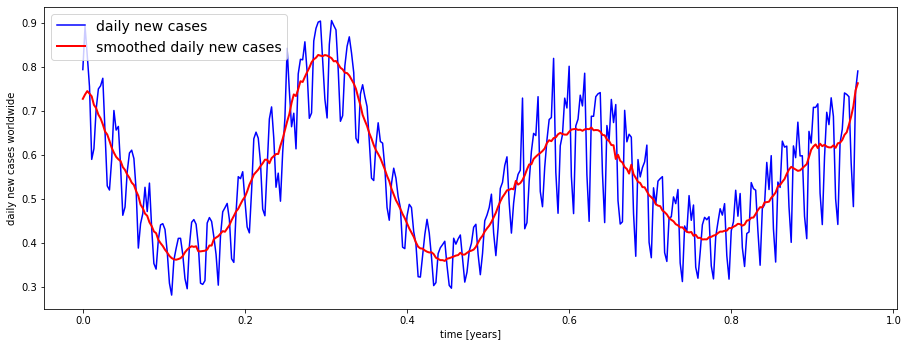

In [4]:
# select time window of interest
d1 = 350
d2 = 700

# plot data in window of interest (normalize case numbers by 10^6)
plt.figure(figsize=(1100/72,400/72))
plt.plot((days[d1:d2]-d1)/365,covid_world[d1:d2,1]/1e06,color='blue',label='daily new cases')
plt.plot((days[d1:d2]-d1)/365,covid_world_smooth[d1:d2]/1e06,linewidth=2.0,color='red', label='smoothed daily new cases')
plt.xlabel('time [years]')
plt.ylabel('daily new cases worldwide')
plt.legend(loc='upper left',fontsize=14)

In [5]:
#### create training data arrays
t_covid = days[d1:d2]-d1   # time array: days
y_covid = t_covid/365      # time array: years

x_covid = covid_world_smooth[d1:d2]/1e06  # normalize COVID numbers per 10^6 people 

# pick range of training data
t_data = y_covid[0:225:1] 
x_data = x_covid[0:225:1]

# collocation points for enforcing ODE (whole window of interest)
t_physics = y_covid[0::1]

In [6]:
# convert arrays to tf tensors
t_data_tf = tf.convert_to_tensor(t_data, dtype=DTYPE)
x_data_tf = tf.convert_to_tensor(x_data, dtype=DTYPE)
t_physics_tf = tf.convert_to_tensor(t_physics, dtype=DTYPE)

T_data = tf.reshape(t_data_tf[:], shape=(t_data.shape[0],1))
X_data = tf.reshape(x_data_tf[:], shape=(x_data.shape[0],1))
T_r = tf.reshape(t_physics_tf[:], shape=(t_physics.shape[0],1))


2022-03-16 11:28:05.030538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This is where I set the weighting for the losses coming from data and physics. Would be good to learn automatically in the future. 

In [7]:
# weighting factor for losses : (1-eps)*loss_data + eps*loss_r
eps = 1e-3

### Model architecture

In [8]:
# Define model architecture
class PINNIdentificationNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, 
            output_dim=1,
            num_hidden_layers=2, 
            num_neurons_per_layer=32,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
        # Initialize variable for mu, k, b: if trainable=True, will be trained along NN
        self.mu = tf.Variable(2.2, trainable=True, dtype=DTYPE)
        self.mu_list = []
        
        self.k = tf.Variable(350.0, trainable=True, dtype=DTYPE)
        self.k_list = []
        
        self.m = tf.Variable(1.0, trainable=False, dtype=DTYPE)
        self.m_list = []
        
        # x-offset around which trajectory oscillates 
        self.b = tf.Variable(0.56, trainable=True, dtype=DTYPE)
        self.b_list = []
        
        
        
    def call(self, T):
        """Forward-pass through neural network."""
        Z = self.hidden[0](T)
        for i in range(1,self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### PINN solver

In [9]:
class PINNSolver_ID():
    def __init__(self, model, T_r):
        self.model = model
        
        # Store collocation points
        self.t = T_r[:,0:1]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t during this GradientTape
            tape.watch(self.t)
            
            # Compute current values u(t,x)
            u = self.model(self.t[:,0:1])
            
            u_t = tape.gradient(u, self.t)
            
        u_tt = tape.gradient(u_t, self.t)
        
        del tape
        
        return self.fun_r(u, u_t, u_tt)
    
    def loss_fn(self, T, u):
        
        # Compute phi_r: loss coming from residual
        r = self.get_r()
        phi_r = eps*tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add loss coming from difference to training data
        for i in range(len(T)):
            u_pred = self.model(T[i:i+1,0:1])
            loss += (1-eps)*tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, T, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(T, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self, u, u_t, u_tt):
        return self.model.m*u_tt + self.model.mu*u_t + self.model.k*(u-self.model.b) # b is vertical offset 
    
    def solve_with_TFoptimizer(self, optimizer, T, u, N=10000):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(T, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()
            
    def callback(self, tr=None):
        mu = self.model.mu.numpy()
        self.model.mu_list.append(mu)
        
        k = self.model.k.numpy()
        self.model.k_list.append(k)
        
        b = self.model.b.numpy()
        self.model.b_list.append(b)
        
        if self.iter % 500 == 0:
            print('It {:05d}: loss = {:10.8e} mu = {:10.8e} k = {:10.8e} b = {:10.8e}'.format(self.iter, self.current_loss, mu, k, b))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        
        n=d2-d1
        t_pred = np.reshape(np.linspace(0,n,n),(n,1))/365
        x_pred = self.model(t_pred)

        # plot prediction
        fig, ax2 = plt.subplots(figsize=(700/72,500/72))
        ax2.set_title('PINN COVID')
        ax2.scatter(t_data,x_data,s=300,edgecolors="tab:green",marker='.',facecolors='none') #observed data points 
        ax2.plot((days[d1:d2]-d1)/365,covid_world[d1:d2,1]/1e06,color='blue',alpha=0.2)
        ax2.plot((days[d1:d2]-d1)/365,covid_world_smooth[d1:d2]/1e06,linewidth=2.0,color='red')
        ax2.plot(t_pred,x_pred,color="black",linewidth=3.0,linestyle="--")
        ax2.legend(('training data','daily cases','daily cases smooth','model prediction'), loc='upper right',fontsize=14)
        ax2.set_xlabel('time [years]',fontsize=14)
        ax2.set_ylabel('daily new cases [per 10^6]]',fontsize=14)
        ax2.set_ylim([0.25,1.0])

        
        return ax2
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(700/72,500/72))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$',fontsize=18)
        ax.set_ylabel('$\\phi^{n_{epoch}}$',fontsize=18)
        return ax
    
    def plot_loss_and_param(self, axs=None):

        color_mu = 'tab:blue'
        color_k = 'tab:red'
        color_b = 'tab:green'

        fig = plt.figure(figsize=(1200/72,800/72))
        gs = fig.add_gridspec(2, 2)
        
        ax1 = plt.subplot(gs[0, 0])
        ax1 = self.plot_loss_history(ax1)
        
        ax2 = plt.subplot(gs[0, 1])
        ax2.plot(range(len(self.hist)), self.model.mu_list,'-',color=color_mu)
        ax2.set_ylabel('$\\mu^{n_{epoch}}$', color=color_mu, fontsize=18)
        ax2.set_xlabel('$n_{epoch}$',fontsize=18)
        
        ax3 = plt.subplot(gs[1, 0])
        ax3.plot(range(len(self.hist)), self.model.k_list,'-',color=color_k)
        ax3.set_ylabel('$k^{n_{epoch}}$', color=color_k, fontsize=18)
        ax3.set_xlabel('$n_{epoch}$',fontsize=18)
        
        ax4 = plt.subplot(gs[1, 1])
        ax4.plot(range(len(self.hist)), self.model.b_list,'-',color=color_b)
        ax4.set_ylabel('$b^{n_{epoch}}$', color=color_b, fontsize=18)
        ax4.set_xlabel('$n_{epoch}$',fontsize=18)

        return (ax1,ax2,ax3,ax4)

In [ ]:
# Initialize model
model = PINNIdentificationNet()
model.build(input_shape=(None,1))

# Initialize PINN solver
solver = PINNSolver_ID(model, T_r)

# Start timer
t0 = time()


#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,6000],[1e-2,1e-3,5e-4])
lr = 5e-3
optim = tf.keras.optimizers.Adam(learning_rate=lr)
solver.solve_with_TFoptimizer(optim, T_data, X_data, N=70000)


# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.24469856e+02 mu = 2.19500041e+00 k = 3.49994995e+02 b = 5.55000007e-01
It 00500: loss = 4.51389074e+00 mu = 2.13887787e+00 k = 3.49905975e+02 b = 5.46201706e-01
It 01000: loss = 4.51343489e+00 mu = 2.13609838e+00 k = 3.49905975e+02 b = 5.46550989e-01
It 01500: loss = 4.51312494e+00 mu = 2.13399553e+00 k = 3.49905975e+02 b = 5.46873152e-01
It 02000: loss = 4.51294851e+00 mu = 2.13280439e+00 k = 3.49905975e+02 b = 5.47134578e-01
It 02500: loss = 4.51285601e+00 mu = 2.13233066e+00 k = 3.49905975e+02 b = 5.47325373e-01
It 03000: loss = 4.51280260e+00 mu = 2.13223481e+00 k = 3.49905975e+02 b = 5.47444940e-01
It 03500: loss = 4.51275015e+00 mu = 2.13223481e+00 k = 3.49905975e+02 b = 5.47502041e-01
It 04000: loss = 4.51268053e+00 mu = 2.13208413e+00 k = 3.49905975e+02 b = 5.47515869e-01
It 04500: loss = 4.51257038e+00 mu = 2.12182856e+00 k = 3.49893646e+02 b = 5.47458291e-01
It 05000: loss = 4.51237822e+00 mu = 2.10778856e+00 k = 3.49877167e+02 b = 5.47437072e-01
It 05500: 

In [ ]:
ax = solver.plot_solution();
axs = solver.plot_loss_and_param();
